# Analyze Census Data with AI

- Use psycopg2 to load the data from the database into Python. 
- Use SQL filter the data to minimize the data transfer. 
- Use pandas and matplotlib to rocess and visualize the loaded data.
- Use OpenAI to assist coding.

### Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Modify and Query Tables with Cursor

###  Insert data
Insert a fake state with fips = 100

In [3]:
fips = '100'
name = 'fake_state'

sql_insert = f""" insert into name(fips,name)
                    values('{fips}','{name}')"""
print(sql_insert)

 insert into name(fips,name)
                    values('100','fake_state')


In [4]:
cur.execute(sql_insert)

In [5]:
conn.commit()

### Query data
Find the fake state

In [6]:
sql_query = f"""select * from name where fips = '{fips}'"""


In [7]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


## Rollback
When errors occur, the cursor will be locked.

The following code will generate an error

In [8]:
cur.execute(sql_insert)

UniqueViolation: duplicate key value violates unique constraint "name_pkey"
DETAIL:  Key (fips)=(100) already exists.


And the cursor is now locked.

In [9]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


Unlock the cursor by using rollback

In [10]:
conn.rollback()

Cursor is now working

In [11]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

('100', 'fake_state')


Delete the fake state

In [12]:
sql_delete = f"""
            delete from name
            where fips = '{fips}'
            """
print(sql_delete)


            delete from name
            where fips = '100'
            


In [13]:
cur.execute(sql_delete)

In [14]:
conn.commit()

The fake state is now deleted. 

In [15]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

## Simple Data Analytics

### Display the VA Income Data Over Time

Define the SQL command. We filter the data based on the ```fips``` as it is a primary key.

In [16]:
sql = """
     select * from name_income
     where fips = '51'
     """

Use pandas to load the data and display the top 5 rows

In [17]:
import pandas as pd

va_df = pd.read_sql(sql, con=conn)
va_df.head() #show the top 5 rows

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_8388/4222419302.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  va_df = pd.read_sql(sql, con=conn)


,fips,name,income,year
0,51,Virginia,54240,2005
1,51,Virginia,56277,2006
2,51,Virginia,59562,2007
3,51,Virginia,61233,2008
4,51,Virginia,59330,2009


Use a line chart to show the VA income over years.

<Axes: xlabel='year'>

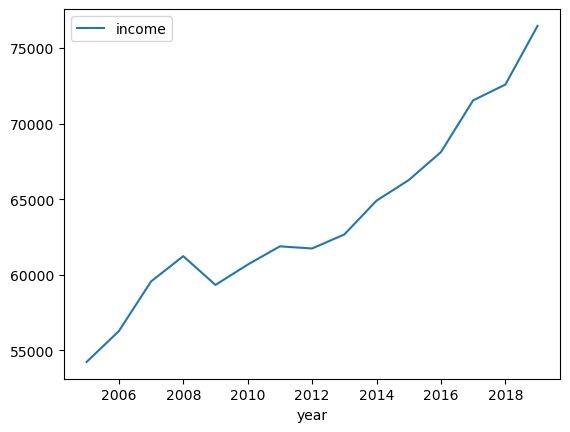

In [18]:
va_df.plot(x='year', y='income')

## Use AI to Assistant Data Analytics

### Install Python Packages

- jupyter-ai-magics: the JupyterLab AI to call Generative AI models

In [19]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.9 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [20]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [21]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands

In [22]:
%load_ext jupyter_ai_magics

Optional: Check the available AI models

'%ai list'

### Explain Existing Codes

In [28]:
%%ai gpt4
What is included in the {va_df}

The given data is a dataset, or a data frame, that includes:

- **fips** - Here, fips refers to Federal Information Processing Standards, which is a numeric code assigned by the National Institute of Standards and Technology to uniquely identify states and counties. In this case, FIPS code 51 stands for Virginia.

- **name** - This column lists the name of the state, which in the given data is always "Virginia".

- **income** - This column lists the median income of households in Virginia for each year, measured in U.S. dollars.

- **year** - This column lists the year during which the corresponding income value was observed. In the data you provided, this ranges from 2005 to 2019.

Each row in the data frame corresponds to the income data for one year.

Optional: explain a code in a specific cell with cell number

`%%ai gpt4`

`explain the code in {In[#]} `

### Create New Codes with AI

In [38]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {va_df}, use the va_df directly, and visualize the result on a line chart with a grid, and value indicators with negative as red and positive as green

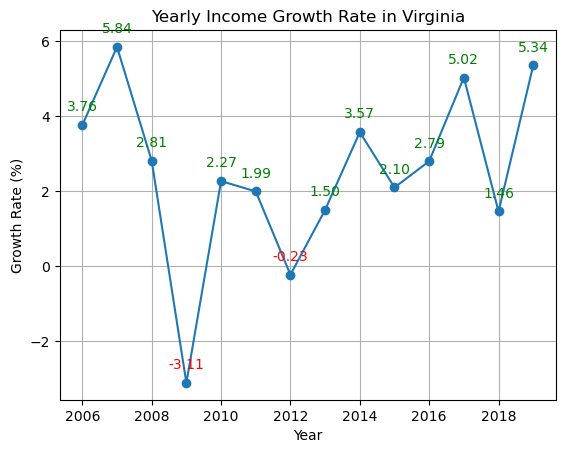

In [39]:
fig, ax = plt.subplots()

# Plotting the growth rate with grid and value indicators
ax.plot(va_df['year'], va_df['growth_rate'], marker='o')
ax.grid(True)

# Adding value indicators with color coding
for x, y in zip(va_df['year'], va_df['growth_rate']):
    if y < 0:
        label_color = 'red'
    else:
        label_color = 'green'
    label = "{:.2f}".format(y)
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color=label_color)

plt.title('Yearly Income Growth Rate in Virginia')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')

plt.show()

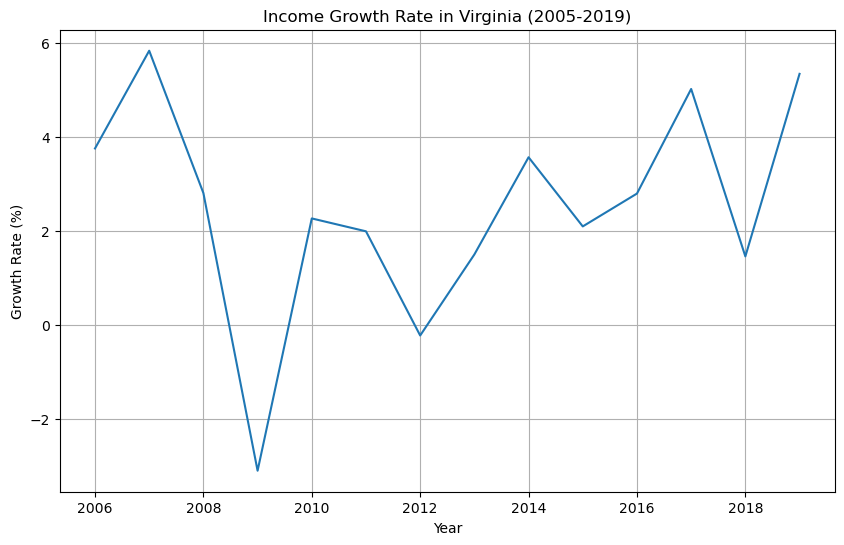

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Constructing the data frame from given data
data = {'fips': [51]*15, 'name': ['Virginia']*15, 
        'income': [54240, 56277, 59562, 61233, 59330, 60674, 61882, 61741, 62666, 64902, 66262, 68114, 71535, 72577, 76456], 
        'year': list(range(2005, 2020))}
va_df = pd.DataFrame(data)

# Adding a 'growth_rate' column to our DataFrame
# We will apply the formula (current year's income - previous year's income) / previous year's income
# We multiply by 100 to get the growth rate as a percentage
va_df['growth_rate'] = va_df['income'].pct_change() * 100

# Plotting the growth rate
plt.figure(figsize=(10,6))
plt.plot(va_df['year'], va_df['growth_rate'])
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.grid(True)
plt.show()

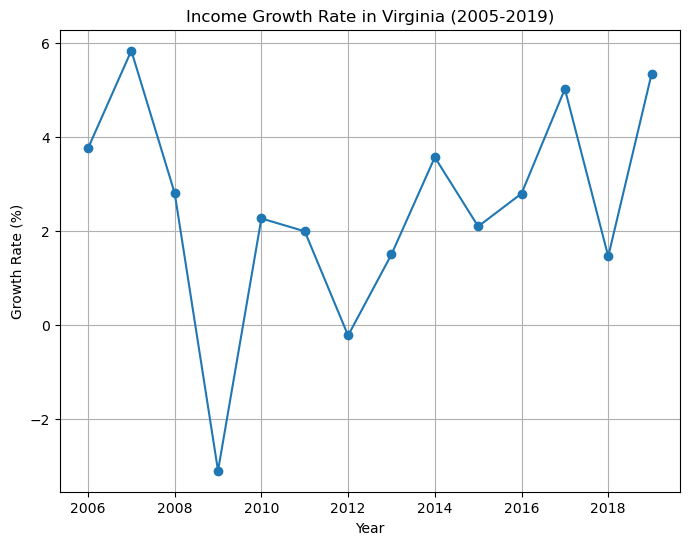

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataframe is named as va_df

va_df['growth_rate'] = va_df['income'].pct_change() * 100

plt.figure(figsize=(8, 6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

### A Complete Analysis with AI

Load the data from database into Python

In [40]:
%%ai gpt4 -f code
We have a view named name_income in an SQL database
You don't need to redefine the connection string
use the {conn} defined in {In[2]} to load all the recored into pandas dataframe 

In [ ]:
import pandas as pd

# SQL query
sql = "SELECT * FROM name_income"

# Load the data into a Pandas DataFrame
df = pd.read_sql(sql, conn)

# Close the cursor and the connection
cur.close()
conn.close()

In [41]:
import pandas as pd

# SQL query to load all records
query = "SELECT * FROM name_income;"

# Execute the query and fetch all records into a pandas dataframe
df = pd.read_sql(query, conn)

# Don't forget to close the connection
conn.close()

In [42]:
import pandas as pd

# Execute the SQL query
cur.execute("SELECT * FROM name_income")

# Fetch all the records
rows = cur.fetchall()

# Get the column names for the dataframe
column_names = [desc[0] for desc in cur.description]

# Create a pandas dataframe
df = pd.DataFrame(rows, columns=column_names)

df.head()

InterfaceError: cursor already closed

In [43]:
%%ai gpt4 
What is the information in {df}

The provided data set represents income statistics from different regions in different years. 

Each row in the table corresponds to one record. 

Here is a breakdown of the four columns present in the table:

1. `fips`: This is probably an acronym for Federal Information Processing Standards. FIPS codes are numeric codes assigned by the National Institute of Standards and Technology to various geographic entities (like states and counties). 

2. `name`: This column indicates the name of the region or state.

3. `income`: This field corresponds to the average income for the respective region and year indicated in the other columns.

4. `year`: This column displays the year in which the income data was recorded.

For example, the first row of the dataset tells us that the average annual income in Alabama in 2005 was $36,879. The last row of the provided data sample suggests that the average annual income in Puerto Rico in 2019 was $20,474.


In [30]:
%%ai gpt4 -f code
Calculate the average year-over-year income growth rate for each state in {df} 
and create a chart to show the result

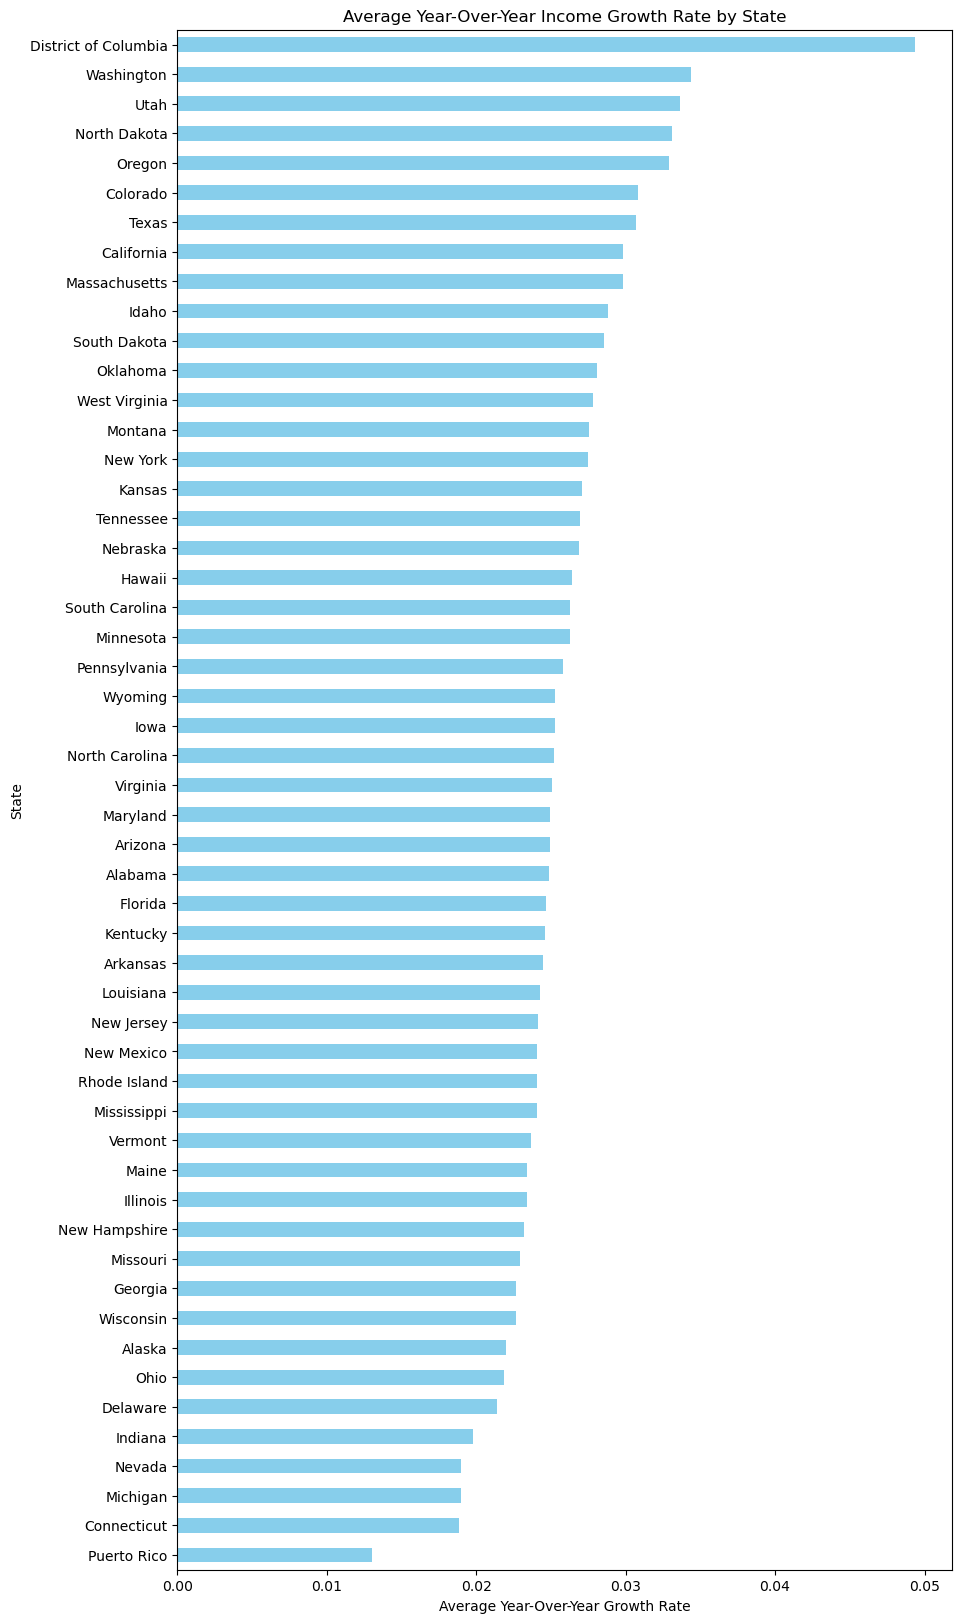

"\nThis Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.\n"

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named df
df['income'] = df['income'].astype(float)
df['year'] = df['year'].astype(int)

# Group by state and calculate the average annual growth rate
df = df.sort_values(['name', 'year'])
df['income_growth'] = df.groupby('name')['income'].pct_change() + 1
df = df.groupby('name')['income_growth'].agg('mean') - 1

# Create a bar chart
df.sort_values().plot(kind='barh', figsize=(10, 20), color='skyblue')

plt.title('Average Year-Over-Year Income Growth Rate by State')
plt.xlabel('Average Year-Over-Year Growth Rate')
plt.ylabel('State')

plt.show()
'''
This Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.
'''

## Close Database Connection

In [44]:
#run the folloiwng code if the connection is not closed

cur.close()
conn.close()